In [3]:
# !pip install geehydro 
# !pip install pmdarima

## Import relevant libraries

In [23]:
import ee, datetime    # Google Earth Engine
import pandas as pd
import numpy as np
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.pyplot as plt
import geopandas as gpd
from sentinelsat.sentinel import read_geojson
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Autentication on Google Earth Engine

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWgOyeXL_H1mGlNKDmOJkMpMW7aRgcbz_0jutodYchyZjJK9fahnSFo

Successfully saved authorization token.


## Select Region

In [29]:
# Visualize the Area Of Interest (AOI) in the map: Zambezia

zambezia_map = folium.Map(location=[-16.653909049, 36.983681369], zoom_start=6) # zambezia in Mozambique
zambezia_map

## Landsat 8 Image Collection

Landsat 8 is operational since 2013. we will be taking every images till date with maximum allowable cloud cover of 20%

In [6]:
# Our chosen Area of Interest is Zambezia province in Mozambique

geojson_file = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              35.859375,
              -17.13029174353376
            ],
            [
              38.408203125,
              -17.13029174353376
            ],
            [
              38.408203125,
              -15.728813770533966
            ],
            [
              35.859375,
              -15.728813770533966
            ],
            [
              35.859375,
              -17.13029174353376
            ]
          ]
        ]
      }
    }
  ]
}

In [30]:
# Landsat 8 take images up to 20% cloud coverage
# Take 2 years image data starting at 2019

landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA").filter(ee.Filter.lt('CLOUD_COVER', 20)).\
          filterDate('2019-09-01','2021-10-10')  




# setting the Area of Interest (AOI)
coords = geojson_file['features'][0]['geometry']['coordinates']
zambezia_AOI =  ee.Geometry.Polygon(coords)

# filter area
landsat_AOI = landsat.filterBounds(zambezia_AOI)

In [31]:
print('Total number of images in the collection is :', landsat_AOI.size().getInfo())

Total number of images in the collection is : 112


In [10]:
# Names of each Landsat 8 band

landsat_AOI.first().bandNames().getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA']

For Landsat 8 dataset:

- B4, B3 and B2 are the Red, Green and Blue bands respectively
- B5 is the Near Infrared (NIR) band

In [11]:
# Plot the 'first' image in the collection

# List of images
listOfImages = landsat_AOI.toList(landsat_AOI.size())

# Plot in RGB color composite
palette = ['red', 'green', 'blue']
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': zambezia_AOI} 
             
zambezia_map.addLayer(ee.Image(listOfImages.get(1)), parameters)
zambezia_map

We can see that the image is around Zambezia

##  NDVI Analysis

NDVI of every image pixels in the images will be calculated by the equation:
\begin{equation}
\mbox{NDVI} = \frac{\mbox{NIR} - \mbox{Red}}{\mbox{NIR} + \mbox{Red}}
\end{equation}

Where, NIR is B5 band and Red is B4 band.
Average NDVI will be calculated on every images to get time-series NDVI of the AOI.

### NDVI Calculation

In [12]:
# Function to calculate 'NDVI' and add a additional band to every images in the collection

def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

with_ndvi = landsat_AOI.map(addNDVI)

In [13]:
# Function to calculate 'average NDVI' on every images in the collection

def meanNDVI(image):
    image = ee.Image(image)
    meanDict = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDVI']),
        geometry = zambezia_AOI,
        scale = image.projection().nominalScale().getInfo(),
                                    maxPixels = 100000,
                                    bestEffort = True
                                  )
    
    return meanDict.get('NDVI').getInfo()

In [14]:
# Calculate 'average NDVI' for every images

listOfImages_ndvi = with_ndvi.select('NDVI').toList(with_ndvi.size())

ndvi_collection = []

for i in range(listOfImages_ndvi.length().getInfo()):
    image = ee.Image(listOfImages_ndvi.get(i-1))
    temp_ndvi = meanNDVI(image)
    ndvi_collection.append(temp_ndvi)

In [15]:
# Extract 'dates' from the image collection

dates = np.array(with_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

## Time-series NDVI Dataframe

In [16]:
# Make a dataframe with 'day' and 'NDVI' columns

ndvi_df = pd.DataFrame(ndvi_collection, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index, format="%Y/%m/%d")
ndvi_df.sort_index(ascending = True, inplace = True)

ndvi_df.head(3)

,ndvi
2019-09-06,0.352855
2019-09-15,0.292515
2019-09-22,0.424860


## Get Daily NDVI Data

Our goal is to train algorithm to predict NDVI which requires the data to have regular interval such as daily, weekly and such. Filtering the data by cloud cover percentage yields irregular interval NDVI data. In this section, we will up-sample to get daily NDVI data with linear interpolation.

In [17]:
# Up-sampple the date column

ndvi_df_daily = ndvi_df.resample('D').median()

# Linear interpolate NDVI data

ndvi_df_daily.interpolate(method='polynomial', order = 1, inplace = True)
ndvi_df_daily.head(3)

,ndvi
2019-09-06,0.352855
2019-09-07,0.346151
2019-09-08,0.339446


## Plot NDVI Data

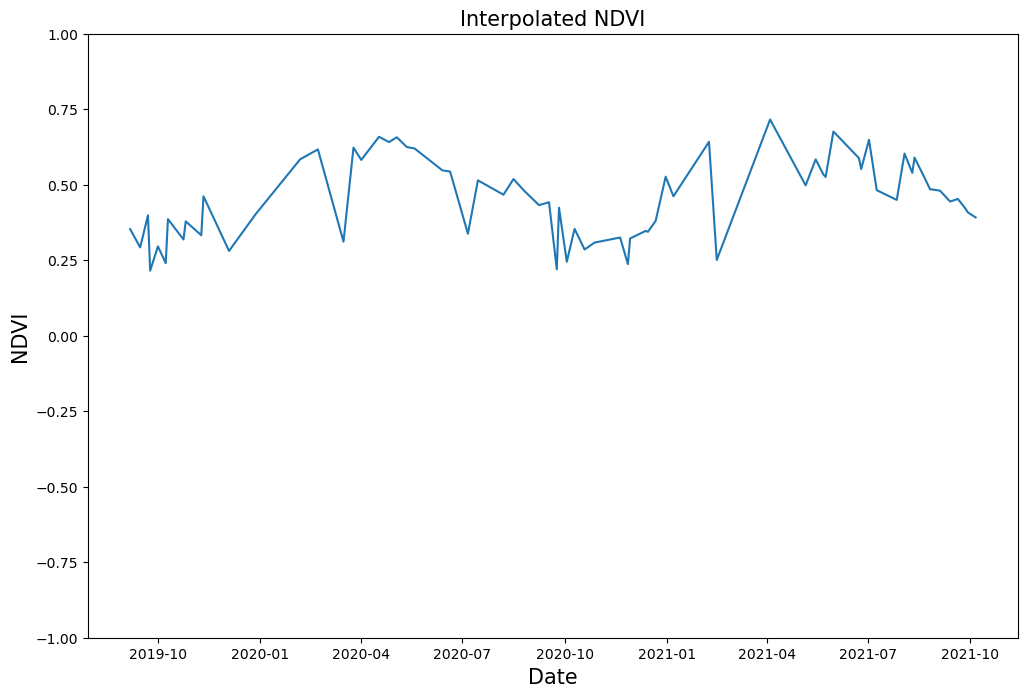

In [32]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(ndvi_df_daily)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.show()

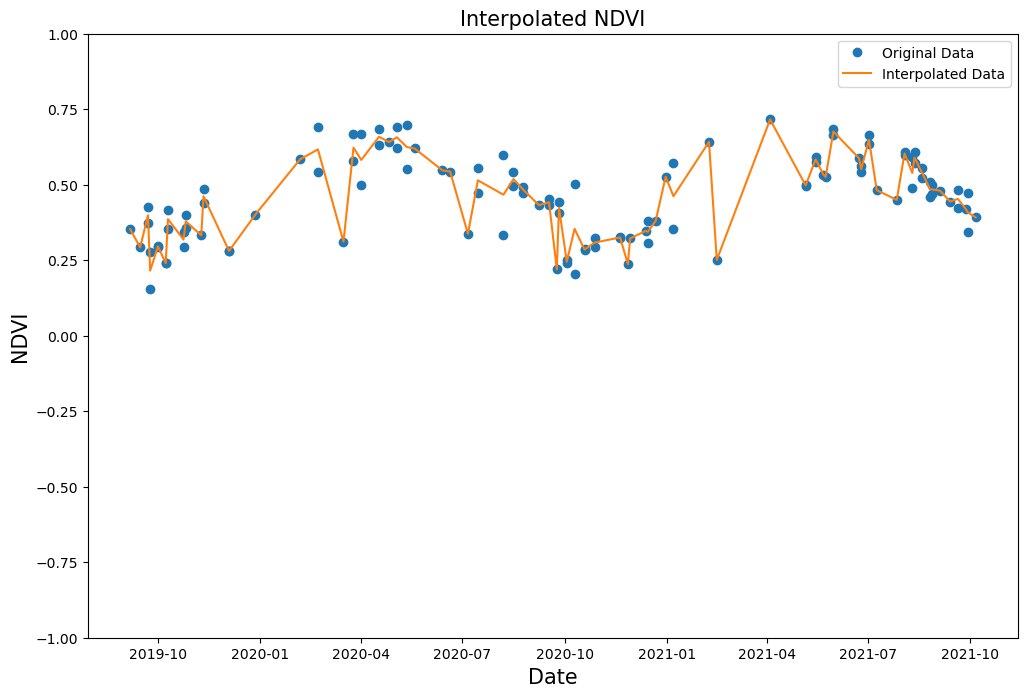

In [20]:
plt.figure(figsize=(12,8), dpi=100)
plt.plot(ndvi_df, 'o')
plt.plot(ndvi_df_daily)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.legend(['Original Data', 'Interpolated Data'])
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.show()